In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [ ]:
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
loc_test = np.load('loc_test.npy')

In [13]:
class ClassicalLSTMModel(nn.Module):
    """LSTM model for multi-step time-series forecasting"""
    def __init__(self, n_features, n_lstm_units=128, num_layers=4, output_len=72):
        super(ClassicalLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_lstm_units,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        self.classifier = nn.Linear(n_lstm_units, output_len)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        final_lstm_output = lstm_out[:, -1, :]
        output = self.classifier(final_lstm_output)
        return torch.sigmoid(output)

In [14]:
def plot_example_predictions(model, X_test, y_test, num_examples=3):
    """Plot example predictions vs actual values"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    with torch.no_grad():
        sample_indices = np.random.choice(len(X_test), num_examples, replace=False)
        plt.figure(figsize=(15, 5 * num_examples))

        for i, idx in enumerate(sample_indices):
            X_sample = torch.tensor(X_test[idx:idx+1]).to(device)
            y_true = y_test[idx]
            y_pred = model(X_sample).cpu().numpy()[0]
            y_pred = (y_pred > 0.5).astype(int)

            plt.subplot(num_examples, 1, i+1)
            hours = np.arange(1, 72 + 1)
            plt.plot(hours, y_true, 'bo-', label='Actual')
            plt.plot(hours, y_pred, 'ro--', label='Predicted')
            plt.title(f'Example {i+1}: Air Quality Prediction (Next 72 Hours)')
            plt.xlabel('Hours Ahead')
            plt.ylabel('Air Quality Class')
            plt.yticks([0, 1], ['Good', 'Poor'])
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.savefig('example_predictions.png', dpi=300, bbox_inches='tight')
        plt.show()

In [15]:
def evaluate_model_per_location_and_hour(model, test_loader, device, location_indices_test, output_seq_len=72):
    """
    Evaluate the model with the needed metrics
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs > 0.5).float()

            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    preds_flat, labels_flat = all_preds.flatten(), all_labels.flatten()

    # All metrics Required
    accuracy = (preds_flat == labels_flat).mean()
    precision = precision_score(labels_flat, preds_flat, average="binary")
    recall = recall_score(labels_flat, preds_flat, average="binary")
    f1 = f1_score(labels_flat, preds_flat, average="binary")
    conf_matrix = confusion_matrix(labels_flat, preds_flat)

    # Per-location metrics
    unique_locations = np.unique(location_indices_test)
    location_metrics = {}
    for loc in unique_locations:
        idx = (location_indices_test == loc)
        preds_loc, labels_loc = all_preds[idx].flatten(), all_labels[idx].flatten()
        location_metrics[int(loc)] = {
            "accuracy": (preds_loc == labels_loc).mean(),
            "precision": precision_score(labels_loc, preds_loc, average="binary"),
            "recall": recall_score(labels_loc, preds_loc, average="binary"),
            "f1": f1_score(labels_loc, preds_loc, average="binary"),
            "confusion_matrix": confusion_matrix(labels_loc, preds_loc)
        }

    # Per-hour metrics
    hour_metrics = []
    for hour in range(output_seq_len):
        preds_hour, labels_hour = all_preds[:, hour], all_labels[:, hour]
        hour_metrics.append({
            "hour": hour + 1,
            "accuracy": (preds_hour == labels_hour).mean(),
            "precision": precision_score(labels_hour, preds_hour, average="binary"),
            "recall": recall_score(labels_hour, preds_hour, average="binary"),
            "f1": f1_score(labels_hour, preds_hour, average="binary"),
            "confusion_matrix": confusion_matrix(labels_hour, preds_hour)
        })

    return {
        "overall": {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "confusion_matrix": conf_matrix
        },
        "per_location": location_metrics,
        "per_hour": hour_metrics,
        "preds_flat": preds_flat,  
        "labels_flat": labels_flat  
    }

In [16]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

In [17]:
if torch.cuda.is_available():
    print(f"✅ Found GPU: {torch.cuda.get_device_name(0)}. Using CUDA.")
else:
    print("❌ No GPU found. The script will run on the CPU.")

✅ Found GPU: NVIDIA GeForce RTX 3050 Laptop GPU. Using CUDA.


In [18]:
batch_size = 512
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# Create and load the model
n_lstm_units = 128
num_layers = 4
model = ClassicalLSTMModel(
    n_features=9,
    n_lstm_units=n_lstm_units,
    num_layers=num_layers,
    output_len=72
)

try:
    model.load_state_dict(torch.load('best_classical_lstm_model.pth', weights_only=True))
    print("Model loaded successfully!")
except FileNotFoundError:
    print("Error: Model file 'best_classical_lstm_model.pth' not found.")
    print("Please make sure the model training has been completed.")
    raise
except Exception as e:
    print(f"Error loading model: {e}")
    raise

print("\nClassical LSTM Model Architecture:")
print(model)

# Set up device and move model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to device: {device}")

Model loaded successfully!

Classical LSTM Model Architecture:
ClassicalLSTMModel(
  (lstm): LSTM(9, 128, num_layers=4, batch_first=True, dropout=0.2)
  (classifier): Linear(in_features=128, out_features=72, bias=True)
)
Model moved to device: cuda


In [22]:
print("\nCalculating detailed accuracy metrics...")
metrics = evaluate_model_per_location_and_hour(
    model, test_loader, device, loc_test
)

# Extract the specific metrics we need
overall_metrics = metrics["overall"]
location_metrics = metrics["per_location"]
hour_metrics = metrics["per_hour"]


Calculating detailed accuracy metrics...



Per-location accuracy (averaged over all 72 hours):
Location 0: 0.9439
Location 1: 0.9539
Location 2: 0.9478
Location 3: 0.9273
Location 4: 0.9344
Location 5: 0.9436
Location 6: 0.9539
Location 7: 0.9579
Location 8: 0.9592
Location 9: 0.9599
Location 10: 0.9605
Location 11: 0.9423
Location 12: 0.9326
Location 13: 0.9347
Location 14: 0.9136
Location 15: 0.9117
Location 16: 0.9031
Location 17: 0.8786
Location 18: 0.8977
Location 19: 0.9272
Location 20: 0.9444
Location 21: 0.9655
Location 22: 0.9573
Location 23: 0.9302
Location 24: 0.9271
Location 25: 0.9470
Location 26: 0.9550
Location 27: 0.9580
Location 28: 0.9589
Location 29: 0.9612
Location 30: 0.9564
Location 31: 0.9512
Location 32: 0.9441
Location 33: 0.9369
Location 34: 0.9243
Location 35: 0.9164
Location 36: 0.9054
Location 37: 0.8917
Location 38: 0.9267
Location 39: 0.9422
Location 40: 0.9436
Location 41: 0.9567
Location 42: 0.9601
Location 43: 0.9470
Location 44: 0.9274
Location 45: 0.9398
Location 46: 0.9517
Location 47: 0.95

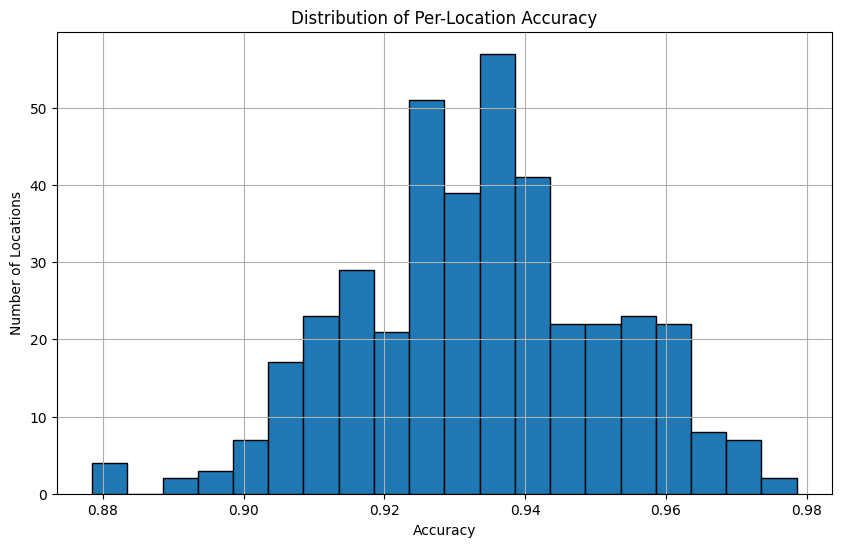

In [23]:
print("\nPer-location accuracy (averaged over all 72 hours):")
for loc in sorted(location_metrics.keys()):
    print(f"Location {loc}: {location_metrics[loc]['accuracy']:.4f}")

# Plot location accuracy distribution
plt.figure(figsize=(10, 6))
plt.hist([loc_metrics['accuracy'] for loc_metrics in location_metrics.values()], bins=20, edgecolor='black')
plt.title('Distribution of Per-Location Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Number of Locations')
plt.grid(True)
plt.savefig('location_accuracy_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


Per-hour accuracy (averaged over all locations):
Hour 1: 0.9812
Hour 2: 0.9769
Hour 3: 0.9659
Hour 4: 0.9548
Hour 5: 0.9449
Hour 6: 0.9374
Hour 7: 0.9254
Hour 8: 0.9241
Hour 9: 0.9307
Hour 10: 0.9359
Hour 11: 0.9436
Hour 12: 0.9441
Hour 13: 0.9403
Hour 14: 0.9427
Hour 15: 0.9408
Hour 16: 0.9359
Hour 17: 0.9296
Hour 18: 0.9272
Hour 19: 0.9278
Hour 20: 0.9300
Hour 21: 0.9313
Hour 22: 0.9315
Hour 23: 0.9331
Hour 24: 0.9345
Hour 25: 0.9343
Hour 26: 0.9341
Hour 27: 0.9346
Hour 28: 0.9344
Hour 29: 0.9330
Hour 30: 0.9284
Hour 31: 0.9203
Hour 32: 0.9200
Hour 33: 0.9272
Hour 34: 0.9348
Hour 35: 0.9425
Hour 36: 0.9438
Hour 37: 0.9404
Hour 38: 0.9439
Hour 39: 0.9419
Hour 40: 0.9366
Hour 41: 0.9295
Hour 42: 0.9291
Hour 43: 0.9283
Hour 44: 0.9296
Hour 45: 0.9312
Hour 46: 0.9318
Hour 47: 0.9322
Hour 48: 0.9335
Hour 49: 0.9318
Hour 50: 0.9329
Hour 51: 0.9321
Hour 52: 0.9311
Hour 53: 0.9291
Hour 54: 0.9250
Hour 55: 0.9142
Hour 56: 0.9132
Hour 57: 0.9207
Hour 58: 0.9293
Hour 59: 0.9381
Hour 60: 0.9393

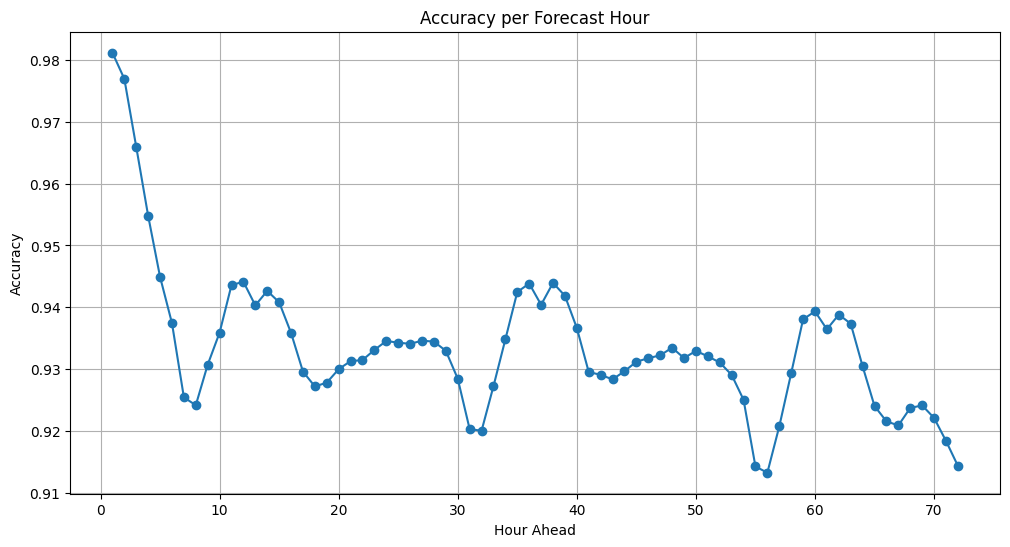

In [24]:
print("\nPer-hour accuracy (averaged over all locations):")
for hour_metrics_dict in hour_metrics:
    hour = hour_metrics_dict["hour"]
    accuracy = hour_metrics_dict["accuracy"]
    print(f"Hour {hour}: {accuracy:.4f}")

# Plot hour accuracy
plt.figure(figsize=(12, 6))
plt.plot([hm["hour"] for hm in hour_metrics], [hm["accuracy"] for hm in hour_metrics], marker='o')
plt.title('Accuracy per Forecast Hour')
plt.xlabel('Hour Ahead')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('hour_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()


Calculating detailed accuracy metrics...

Overall Confusion Matrix:


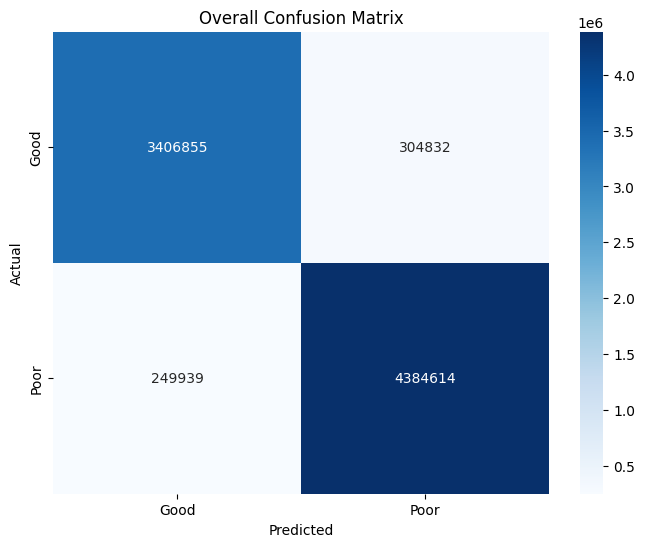


Overall Metrics:
Accuracy: 0.9335
Precision: 0.9350
Recall: 0.9461
F1 Score: 0.9405


In [25]:
# After getting metrics
print("\nCalculating detailed accuracy metrics...")

# Extract metrics
overall_metrics = metrics["overall"]
location_metrics = metrics["per_location"]
hour_metrics = metrics["per_hour"]
preds_flat = metrics["preds_flat"]
labels_flat = metrics["labels_flat"]

# Plot overall confusion matrix
print("\nOverall Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(overall_metrics['confusion_matrix'], 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['Good', 'Poor'],
            yticklabels=['Good', 'Poor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Overall Confusion Matrix')
plt.savefig('overall_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print overall metrics
print("\nOverall Metrics:")
print(f"Accuracy: {overall_metrics['accuracy']:.4f}")
print(f"Precision: {overall_metrics['precision']:.4f}")
print(f"Recall: {overall_metrics['recall']:.4f}")
print(f"F1 Score: {overall_metrics['f1']:.4f}")


Generating example predictions...


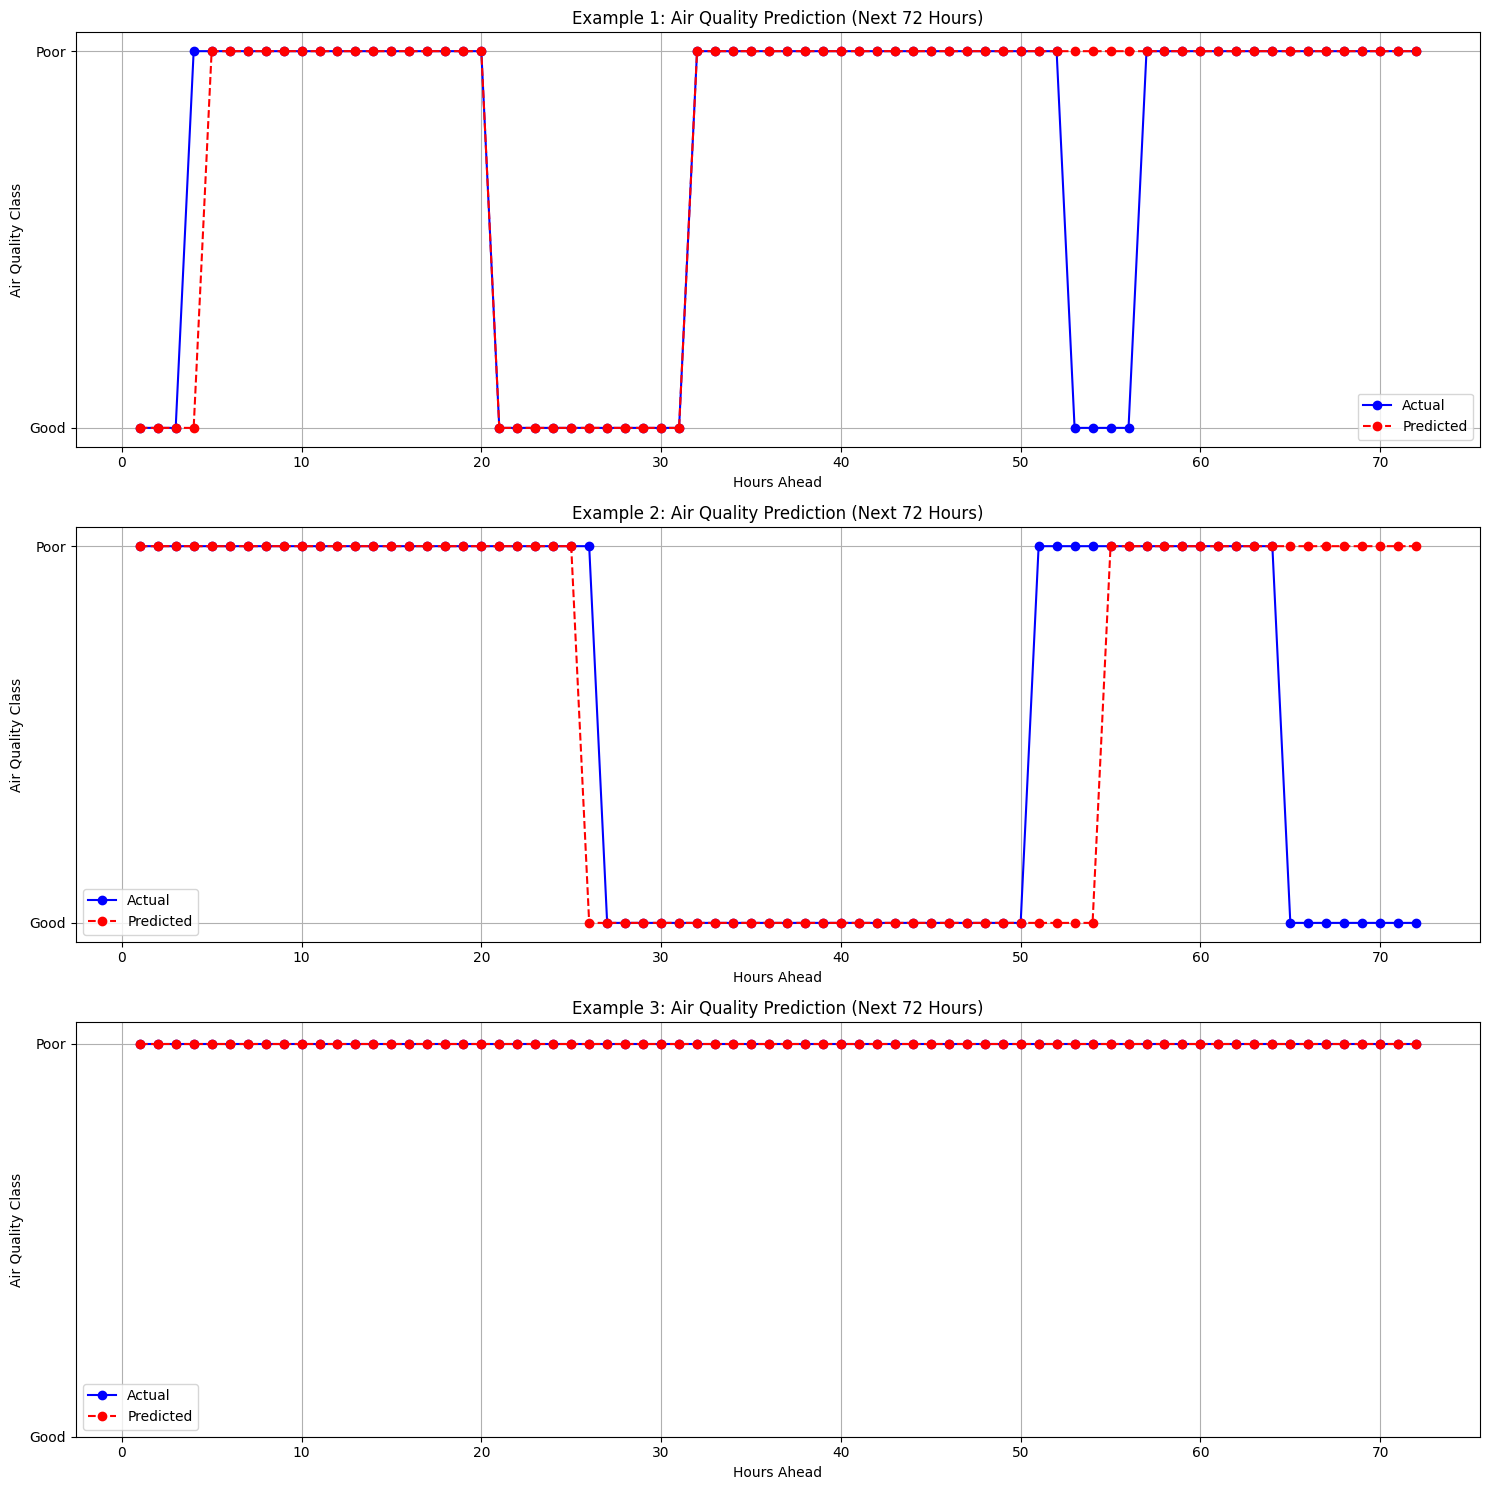


Testing complete. Results saved.


In [26]:
print("\nGenerating example predictions...")
plot_example_predictions(model, X_test, y_test, num_examples=3)

print("\nTesting complete. Results saved.")